<a href="https://colab.research.google.com/github/mar-an/exercise/blob/master/Airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version
!java -version

Python 3.7.10
openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
!cat /etc/issue

Ubuntu 18.04.5 LTS \n \l



In [ ]:
ls -all

total 16
drwxr-xr-x 1 root root 4096 May  6 13:44 ./
drwxr-xr-x 1 root root 4096 May 31 06:20 ../
drwxr-xr-x 4 root root 4096 May  6 13:43 .config/
drwxr-xr-x 1 root root 4096 May  6 13:44 sample_data/


In [ ]:
!whoami

root


Instalacja srodowiska

In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz 
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz 
!pip install -q findspark

import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/default-java"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"

In [3]:
!ls -l /content/spark-3.1.1-bin-hadoop2.7/jars/graphframes-0.8.0-spark3.0-s_2.12.jar

-rw-r--r-- 1 root root 243265 Jun  1 06:35 /content/spark-3.1.1-bin-hadoop2.7/jars/graphframes-0.8.0-spark3.0-s_2.12.jar


Instalacja biblioteki Graphframe dla Pythona

In [4]:
!pip install graphframes

     |████████████████████████████████| 163kB 12.3MB/s 


Instalacja biblioteki Graphframe dla Sparka

In [ ]:
#!/content/spark-3.1.1-bin-hadoop2.7/bin/pyspark --packages graphframes:graphframes:0.8.0-spark3.0-s_2.12 --jars graphframes-0.8.0-spark3.0-s_2.12.jar
!$SPARK_HOME/bin/spark-shell --jars graphframes-0.8.0-spark3.0-s_2.12.jar

Tworzymy nowy projekt i ustawiamy zmienne środowiska

In [6]:
import findspark
findspark.init()

from pyspark.sql.types import *
from pyspark.sql import functions as F

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('baza').getOrCreate()

Wczytanie danych z plików

In [18]:
#wczytanie pliku z lotniskami
rawDataAirport = spark.read.csv("sample_data/airports.dat");

C_rawDataAirport = (rawDataAirport.select("_c0", "_c1", "_c2", "_c3", "_c4", "_c6", "_c7")
                 #.filter("_c3 = 'United States'")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c3", "country")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude"))

C_rawDataAirport.show(truncate=False);



#wczytanie pliku z lotami
rawDataRoutes = spark.read.csv("sample_data/routes.dat");
C_rawDataRoutes = (rawDataRoutes.select("_c0", "_c1", "_c2", "_c3", "_c4", "_c5", "_c6", "_c7", "_c8")   
                .withColumnRenamed("_c0", "c0")
                .withColumnRenamed("_c1", "c1")
                .withColumnRenamed("_c2", "src")
                .withColumnRenamed("_c3", "c3")
                .withColumnRenamed("_c4", "dst")
                .withColumnRenamed("_c5", "c5")
                .withColumnRenamed("_c6", "c6")
                .withColumnRenamed("_c7", "c7")
                .withColumnRenamed("_c8", "c8"))
C_rawDataRoutes.show(truncate=False);

#utworzenie grafa
from graphframes import *
g = GraphFrame(C_rawDataAirport, C_rawDataRoutes)

+---+-------------------------------------------+--------------+----------------+---+------------------+-------------------+
|_c0|_c1                                        |_c2           |country         |id |latitude          |longitude          |
+---+-------------------------------------------+--------------+----------------+---+------------------+-------------------+
|1  |Goroka Airport                             |Goroka        |Papua New Guinea|GKA|-6.081689834590001|145.391998291      |
|2  |Madang Airport                             |Madang        |Papua New Guinea|MAG|-5.20707988739    |145.789001465      |
|3  |Mount Hagen Kagamuga Airport               |Mount Hagen   |Papua New Guinea|HGU|-5.826789855957031|144.29600524902344 |
|4  |Nadzab Airport                             |Nadzab        |Papua New Guinea|LAE|-6.569803         |146.725977         |
|5  |Port Moresby Jacksons International Airport|Port Moresby  |Papua New Guinea|POM|-9.443380355834961|147.22000122070312 |


Wykaz polskich lotnisk

In [8]:
g.vertices.filter("country = 'Poland'").show(n=100, truncate=False);
#g.vertices.show(n=100, truncate=False);

+-----+-------------------------------------------+-------------------+-------+---+------------------+------------------+
|_c0  |_c1                                        |_c2                |country|id |latitude          |longitude         |
+-----+-------------------------------------------+-------------------+-------+---+------------------+------------------+
|667  |Babice Airport                             |Warsaw             |Poland |\N |52.26850128173828 |20.910999298095703|
|668  |Gdańsk Lech Wałęsa Airport                 |Gdansk             |Poland |GDN|54.377601623535156|18.46619987487793 |
|669  |Kraków John Paul II International Airport  |Krakow             |Poland |KRK|50.077702         |19.7848           |
|670  |Muchowiec Airport                          |Katowice           |Poland |\N |50.23809814453125 |19.03420066833496 |
|671  |Katowice International Airport             |Katowice           |Poland |KTW|50.4743           |19.08             |
|673  |Mielec Airport   

Ilość lotów wychodzących z polskich lotnisk

In [ ]:
#kody wszystkich lotnisk z ilością lotów pogrupowanych po src (routes.dat)
airports = (g.edges
 .groupBy("src")
 .agg(F.count("src").alias("flights1"))
 .sort("flights1", ascending=False))

#połączenie obu struktur danych po kolumnie i z ilościa lotów src
dest = (g.vertices
                      .join(airports, airports.src == g.vertices.id)
                      .select("_c1", "id", "flights1", "country")
                      .filter("country = 'Poland'")
                      .sort("flights1", ascending=False))


airports.show(10)
dest.show(n=50, truncate=False)

+---+--------+
|src|flights1|
+---+--------+
|ATL|     915|
|ORD|     558|
|PEK|     535|
|LHR|     527|
|CDG|     524|
|FRA|     497|
|LAX|     492|
|DFW|     469|
|JFK|     456|
|AMS|     453|
+---+--------+
only showing top 10 rows

+-------------------------------------------+---+--------+-------+
|_c1                                        |id |flights1|country|
+-------------------------------------------+---+--------+-------+
|Warsaw Chopin Airport                      |WAW|120     |Poland |
|Kraków John Paul II International Airport  |KRK|57      |Poland |
|Gdańsk Lech Wałęsa Airport                 |GDN|51      |Poland |
|Copernicus Wrocław Airport                 |WRO|33      |Poland |
|Katowice International Airport             |KTW|28      |Poland |
|Modlin Airport                             |WMI|26      |Poland |
|Poznań-Ławica Airport                      |POZ|21      |Poland |
|Rzeszów-Jasionka Airport                   |RZE|11      |Poland |
|"Szczecin-Goleniów ""Solid

Ilość lotów przychodzących z polskich lotnisk

In [ ]:
#to samo dla połaczenia ramek do ilosci lotów dst
airports1 = (g.edges
 .groupBy("dst")
 .agg(F.count("dst").alias("flights2"))
 .sort("flights2", ascending=False))

arrival = (g.vertices
                      .join(airports1, airports1.dst == g.vertices.id)
                      .select("_c1", "id", "flights2", "country")
                      .filter("country = 'Poland'")
                      .sort("flights2", ascending=False))

arrival.show(n=100,truncate=False)

+-------------------------------------------+---+--------+-------+
|_c1                                        |id |flights2|country|
+-------------------------------------------+---+--------+-------+
|Warsaw Chopin Airport                      |WAW|120     |Poland |
|Kraków John Paul II International Airport  |KRK|57      |Poland |
|Gdańsk Lech Wałęsa Airport                 |GDN|50      |Poland |
|Copernicus Wrocław Airport                 |WRO|33      |Poland |
|Katowice International Airport             |KTW|28      |Poland |
|Modlin Airport                             |WMI|26      |Poland |
|Poznań-Ławica Airport                      |POZ|21      |Poland |
|Rzeszów-Jasionka Airport                   |RZE|11      |Poland |
|"Szczecin-Goleniów ""Solidarność"" Airport"|SZZ|7       |Poland |
|Lublin Airport                             |LUZ|6       |Poland |
|Bydgoszcz Ignacy Jan Paderewski Airport    |BZG|3       |Poland |
+-------------------------------------------+---+--------+----

Loty międzynarodowe z polskich lotnisk

Loty międzynarodowe z polskich lotnisk - SQL

In [ ]:
polskie_lotniska = g.vertices.filter("country = 'Poland'")
polskie_lotniska.createOrReplaceTempView('polskie_lotniska')
g.edges.createOrReplaceTempView('edges')

### przyloty z zagranicy do polski -z grupowaniem po lotnisku
#spark.sql('''
#SELECT _c1, count(dst), count(src)
#FROM edges
#LEFT JOIN polskie_lotniska
#ON polskie_lotniska.id = edges.src
#WHERE (edges.dst NOT IN (SELECT id FROM polskie_lotniska)) AND (edges.src  IN (SELECT id FROM polskie_lotniska) )
#GROUP by _c1
#ORDER by count(dst) desc
#''').show(n=200, truncate=False)


### przyloty z zagranicy do polski - wyniki bez grupowania
#spark.sql('''
#SELECT _c1, dst, src
#FROM edges
#LEFT JOIN polskie_lotniska
#ON polskie_lotniska.id = edges.src
#WHERE (edges.dst NOT IN (SELECT id FROM polskie_lotniska)) AND (edges.src IN (SELECT id FROM polskie_lotniska) )
#ORDER by _c1 desc
#''').show(n=200, truncate=False)


### loty krajowe -z grupowaniem po lotnisku
spark.sql('''
SELECT _c1, count(dst), count(src)
FROM edges
LEFT JOIN polskie_lotniska
ON polskie_lotniska.id = edges.dst
WHERE (edges.dst IN (SELECT id FROM polskie_lotniska)) AND (edges.src IN (SELECT id FROM polskie_lotniska))
GROUP by _c1
ORDER by count(dst) desc
''').show(n=200, truncate=False)


### loty krajowe -bez grupowania
#spark.sql('''
#SELECT _c1, dst, src
#FROM edges
#LEFT JOIN polskie_lotniska
#ON polskie_lotniska.id = edges.dst
#WHERE (edges.dst IN (SELECT id FROM polskie_lotniska)) AND (edges.src IN (SELECT id FROM polskie_lotniska))
#ORDER by _c1 desc
#''').show(n=200, truncate=False)


+-------------------------------------------+----------+----------+
|_c1                                        |count(dst)|count(src)|
+-------------------------------------------+----------+----------+
|Warsaw Chopin Airport                      |7         |7         |
|Gdańsk Lech Wałęsa Airport                 |5         |5         |
|Copernicus Wrocław Airport                 |3         |3         |
|Kraków John Paul II International Airport  |2         |2         |
|Modlin Airport                             |2         |2         |
|Rzeszów-Jasionka Airport                   |1         |1         |
|Poznań-Ławica Airport                      |1         |1         |
|"Szczecin-Goleniów ""Solidarność"" Airport"|1         |1         |
|Katowice International Airport             |1         |1         |
|Lublin Airport                             |1         |1         |
+-------------------------------------------+----------+----------+



In [ ]:
#polskie lotniska za pomocą SQL
spark.sql('''SELECT *
FROM polskie_lotniska
sort by _c1''').show(n=100, truncate=False)

+-----+-------------------------------------------+-------------------+-------+---+------------------+------------------+
|_c0  |_c1                                        |_c2                |country|id |latitude          |longitude         |
+-----+-------------------------------------------+-------------------+-------+---+------------------+------------------+
|676  |"Szczecin-Goleniów ""Solidarność"" Airport"|Szczecin           |Poland |SZZ|53.584701538100006|14.902199745199999|
|667  |Babice Airport                             |Warsaw             |Poland |\N |52.26850128173828 |20.910999298095703|
|11790|Biała Podlaska Airfield                    |Biała Podlaska     |Poland |BXP|52.00078          |23.1325278        |
|6499 |Bielsko Biala Airport                      |Bielsko-Biala      |Poland |\N |49.80500030517578 |19.00189971923828 |
|5591 |Bydgoszcz Ignacy Jan Paderewski Airport    |Bydgoszcz          |Poland |BZG|53.096801757799994|17.9776992798     |
|11791|Cewice Air Base  

Przeszukiwanie grafu

algorytm BFS - wyznaczenie najkrótszej scieżki

In [10]:
from_expr = 'id = "KTW"'
to_expr = 'id = "KZN"'
ord_to_ckb = g.bfs(from_expr, to_expr, maxPathLength=3)
print(ord_to_ckb.columns)

columns = [column for column in ord_to_ckb.columns if not column.startswith("v")]  #tylko węzły, pomijamy krawędzie
ord_to_ckb.select(columns).count()
ord_to_ckb.select(columns).show(n=50,truncate=False)

['from', 'e0', 'v1', 'e1', 'v2', 'e2', 'to']
+----------------------------------------------------------------------------+-------------------------------------------------+----------------------------------------------------------------------+--------------------------------------------------+-----------------------------------------------------------------------------------------+
|from                                                                        |e0                                               |e1                                                                    |e2                                                |to                                                                                       |
+----------------------------------------------------------------------------+-------------------------------------------------+----------------------------------------------------------------------+--------------------------------------------------+-----------------------

Popularne lotniska, Które lotniska mają najwięcej lotów? Możemy obliczyć liczbę wylotów przy użyciu algorytmu Degree Centrality:

Algorytm który oblicza liczbę łączy powiązań dla danego wierzchołka grafu z uwzględnieniem połączeń wychodzących i przychodzących


In [29]:
total_degree = g.degrees
in_degree = g.inDegrees
out_degree = g.outDegrees

(total_degree.join(in_degree, "id", how="left")
.join(out_degree, "id", how="left")
.join(g.vertices, "id", how="left")
#.filter("country = 'Poland'")
.fillna(0)
.sort("degree", ascending=False)
.show(n=100, truncate=False))

+---+------+--------+---------+-----+-----------------------------------------------------------------+-----------------+--------------------+-------------------+-------------------+
|id |degree|inDegree|outDegree|_c0  |_c1                                                              |_c2              |country             |latitude           |longitude          |
+---+------+--------+---------+-----+-----------------------------------------------------------------+-----------------+--------------------+-------------------+-------------------+
|ATL|1826  |911     |915      |3682 |Hartsfield Jackson Atlanta International Airport                 |Atlanta          |United States       |33.6367            |-84.428101         |
|ORD|1108  |550     |558      |3830 |Chicago O'Hare International Airport                             |Chicago          |United States       |41.9786            |-87.9048           |
|PEK|1069  |534     |535      |3364 |Beijing Capital International Airport           

Analiza danych lotniczych z USA

Wczytanie wartości opisy portów lotniczych - węzły (node)

In [11]:
nodes = spark.read.csv("sample_data/airports.csv", header=False)

nodes.columns

cleaned_nodes = (nodes.select("_c0", "_c1", "_c3", "_c4", "_c6", "_c7")
                 .filter("_c3 = 'United States'")
                 #.withColumnRenamed("_c0", "lp")
                 .withColumnRenamed("_c1", "name")
                 .withColumnRenamed("_c4", "id")
                 .withColumnRenamed("_c6", "latitude")
                 .withColumnRenamed("_c7", "longitude")
                 .drop("_c3"))

cleaned_nodes = cleaned_nodes[cleaned_nodes["id"] != "\\N"]
cleaned_nodes.show()

+----+--------------------+---+------------------+-------------------+
| _c0|                name| id|          latitude|          longitude|
+----+--------------------+---+------------------+-------------------+
|3411|Barter Island LRR...|BTI|     70.1340026855|     -143.582000732|
|3413|Cape Lisburne LRR...|LUR|       68.87509918|       -166.1100006|
|3414|Point Lay LRRS Ai...|PIZ|       69.73290253|       -163.0050049|
|3415|Hilo Internationa...|ITO|19.721399307250977|-155.04800415039062|
|3416|Orlando Executive...|ORL|   28.545499801636|   -81.332901000977|
|3417|     Bettles Airport|BTT|       66.91390228|        -151.529007|
|3418|       Clear Airport|Z84|         64.301201|        -149.119995|
|3419|Indian Mountain L...|UTO|       65.99279785|       -153.7039948|
|3420|  Fort Yukon Airport|FYU| 66.57150268554688|            -145.25|
|3421|Sparrevohn LRRS A...|SVW|       61.09740067|       -155.5740051|
|3422|Bryant Army Heliport|FRN|       61.26639938|       -149.6529999|
|3423|

sprawdz typ danych

In [ ]:
print("typ sktuktury danych dla zmiennej nodes {0}".format(type(nodes)))
print("typ sktuktury danych dla zmiennej cleaned_nodes {0}".format(type(cleaned_nodes)))

typ sktuktury danych dla zmiennej nodes <class 'pyspark.sql.dataframe.DataFrame'>
typ sktuktury danych dla zmiennej cleaned_nodes <class 'pyspark.sql.dataframe.DataFrame'>


oblicz rozmiar ramki

In [ ]:
print("Rozmiar ramki node {0}".format(nodes.count()))
print("Rozmiar ramki cleaned_node {0}".format(cleaned_nodes.count()))

Rozmiar ramki node 7184
Rozmiar ramki cleaned_node 1333


In [ ]:
cleaned_nodes.show(10, truncate=False)

+----+----------------------------+---+------------------+-------------------+
|_c0 |name                        |id |latitude          |longitude          |
+----+----------------------------+---+------------------+-------------------+
|3411|Barter Island LRRS Airport  |BTI|70.1340026855     |-143.582000732     |
|3413|Cape Lisburne LRRS Airport  |LUR|68.87509918       |-166.1100006       |
|3414|Point Lay LRRS Airport      |PIZ|69.73290253       |-163.0050049       |
|3415|Hilo International Airport  |ITO|19.721399307250977|-155.04800415039062|
|3416|Orlando Executive Airport   |ORL|28.545499801636   |-81.332901000977   |
|3417|Bettles Airport             |BTT|66.91390228       |-151.529007        |
|3418|Clear Airport               |Z84|64.301201         |-149.119995        |
|3419|Indian Mountain LRRS Airport|UTO|65.99279785       |-153.7039948       |
|3420|Fort Yukon Airport          |FYU|66.57150268554688 |-145.25            |
|3421|Sparrevohn LRRS Airport     |SVW|61.09740067  

Wczytanie wartości relacji - krawędzie (egde) (dane o połączeniach za 1 miesiąc)


In [12]:
relationships = spark.read.csv("sample_data/188591317_T_ONTIME.csv.gz", header=True)

cleaned_relationships = (relationships
                         .select("ORIGIN", "DEST", "FL_DATE", "DEP_DELAY", "ARR_DELAY",
                                 "DISTANCE", "TAIL_NUM", "FL_NUM", "CRS_DEP_TIME",
                                 "CRS_ARR_TIME", "UNIQUE_CARRIER")
                         .withColumnRenamed("ORIGIN", "src")
                         .withColumnRenamed("DEST", "dst")
                         .withColumnRenamed("DEP_DELAY", "deptDelay")
                         .withColumnRenamed("ARR_DELAY", "arrDelay")
                         .withColumnRenamed("TAIL_NUM", "tailNumber")
                         .withColumnRenamed("FL_NUM", "flightNumber")
                         .withColumnRenamed("FL_DATE", "date")
                         .withColumnRenamed("CRS_DEP_TIME", "time")
                         .withColumnRenamed("CRS_ARR_TIME", "arrivalTime")
                         .withColumnRenamed("DISTANCE", "distance")
                         .withColumnRenamed("UNIQUE_CARRIER", "airline")
                         .withColumn("deptDelay", F.col("deptDelay").cast(FloatType()))
                         .withColumn("arrDelay", F.col("arrDelay").cast(FloatType()))
                         .withColumn("time", F.col("time").cast(IntegerType()))
                         .withColumn("arrivalTime", F.col("arrivalTime").cast(IntegerType()))
                         )

In [ ]:
print("Rozmiar ramki relationship {0}".format(relationships.count()))
print("Rozmiar ramki cleaned_relationships {0}".format(cleaned_relationships.count()))

Rozmiar ramki relationship 616529
Rozmiar ramki cleaned_relationships 616529


In [ ]:
cleaned_relationships.show(10, truncate=False)
cleaned_relationships.count()

+---+---+----------+---------+--------+--------+----------+------------+----+-----------+-------+
|src|dst|date      |deptDelay|arrDelay|distance|tailNumber|flightNumber|time|arrivalTime|airline|
+---+---+----------+---------+--------+--------+----------+------------+----+-----------+-------+
|ATL|SLC|2018-05-01|-1.0     |-3.0    |1590.00 |N6709     |15          |1920|2120       |DL     |
|LAS|DTW|2018-05-01|7.0      |-2.0    |1749.00 |N820DN    |16          |1400|2102       |DL     |
|DTW|LAS|2018-05-01|-4.0     |23.0    |1749.00 |N856DN    |17          |1757|1915       |DL     |
|MSP|DTW|2018-05-01|-6.0     |-13.0   |528.00  |N329NB    |22          |1335|1615       |DL     |
|DTW|MSP|2018-05-01|6.0      |6.0     |528.00  |N697DL    |23          |1556|1650       |DL     |
|SAN|ATL|2018-05-01|-2.0     |-18.0   |1892.00 |N323DN    |30          |745 |1458       |DL     |
|ATL|DFW|2018-05-01|-3.0     |-6.0    |731.00  |N901DE    |31          |1938|2102       |DL     |
|DFW|ATL|2018-05-01|

616529

In [ ]:
print((cleaned_relationships.count(), len(cleaned_relationships.columns)))

(616529, 11)


inicjalizacja grafów

In [13]:
#!export SPARK_OPTS="--packages graphframes:graphframes:0.8.0-spark3.0-s_2.12"
#from pyspark import SparkContext
#spark.sparkContext.addPyFile('/content/spark-3.1.1-bin-hadoop2.7/jars/graphframes-0.8.0-spark3.0-s_2.12.jar')
from graphframes import *
g = GraphFrame(cleaned_nodes, cleaned_relationships)

sprawdz typ danych

In [ ]:
print("typ sktuktury danych dla zmiennej g {0}".format(type(g)))

typ sktuktury danych dla zmiennej g <class 'graphframes.graphframe.GraphFrame'>


ile lotniksk mamy w grafie?

In [14]:
g.vertices.count()

1333

ile mamy polączeń między lotniskami?

In [ ]:
g.edges.count()

616529

Odczyt z pliku referencji kodów do nazw linii lotniczych. 

In [ ]:
airlines_reference = (spark.read.csv("sample_data/airlines.csv")
.select("_c1", "_c3")
.withColumnRenamed("_c1", "name")
.withColumnRenamed("_c3", "code"))
airlines_reference = airlines_reference[airlines_reference["code"] != "null"]
airlines_reference.show(10, truncate=False)
airlines_reference.count()

+--------------------+----+
|name                |code|
+--------------------+----+
|Unknown             |-   |
|Private flight      |-   |
|1Time Airline       |1T  |
|40-Mile Air         |Q5  |
|Ansett Australia    |AN  |
|Abacus International|1B  |
|Abelag Aviation     |W9  |
|Aigle Azur          |ZI  |
|Aloha Airlines      |AQ  |
|American Airlines   |AA  |
+--------------------+----+
only showing top 10 rows



1537

Identyfikacja wszystkich linii lotniczych i ustalenie ile lotów przypada na każdą z nich. 

In [ ]:
#wykaz linii lotniczych - pobrany z grafa edges (loty)
airlines = (g.edges
 .groupBy("airline")
 .agg(F.count("airline").alias("flights1"))
 .sort("flights1", ascending=False))

full_name_airlines = (airlines_reference
                      .join(airlines, airlines.airline == airlines_reference.code)
                      .select("code", "name", "flights1")
                      .sort("flights1", ascending=False))



#ax = (full_name_airlines.toPandas()
     # .plot(kind='bar', x='name', y='flights1', legend=None))
        

airlines.show(truncate= False)
full_name_airlines.show(n=100,truncate = False)


+-------+--------+
|airline|flights1|
+-------+--------+
|WN     |116849  |
|DL     |81735   |
|AA     |77957   |
|OO     |65157   |
|UA     |52816   |
|YX     |27398   |
|B6     |26513   |
|MQ     |25364   |
|OH     |23869   |
|AS     |22974   |
|9E     |21097   |
|YV     |17866   |
|EV     |16661   |
|NK     |14889   |
|F9     |10297   |
|G4     |8033    |
|HA     |7054    |
+-------+--------+

+----+---------------------------+--------+
|code|name                       |flights1|
+----+---------------------------+--------+
|WN  |Southwest Airlines         |116849  |
|DL  |Delta Air Lines            |81735   |
|AA  |American Airlines          |77957   |
|OO  |SkyWest                    |65157   |
|UA  |United Airlines            |52816   |
|YX  |Midwest Airlines           |27398   |
|B6  |JetBlue Airways            |26513   |
|MQ  |American Eagle Airlines    |25364   |
|OH  |Comair                     |23869   |
|AS  |Alaska Airlines            |22974   |
|9E  |Pinnacle Airlines     

In [ ]:
print("typ sktuktury danych dla zmiennej g {0}".format(type(g)))

typ sktuktury danych dla zmiennej g <class 'graphframes.graphframe.GraphFrame'>


max opóżnienia w lotach dla dst

In [20]:
delayed_flights = (g.edges                      #zmienna z połączeniami (g.edges) filtrowana dla opóźnień więszych od 0
.filter("deptDelay > 0")
.groupBy("dst")
.agg(F.avg("deptDelay"), F.count("deptDelay"))
.withColumn("averageDelay",F.round(F.col("avg(deptDelay)"), 2))
.withColumn("numberOfDelays",F.col("count(deptDelay)")))
delayed_flights.show(n=10, truncate=False)

(delayed_flights                                 #join pomiędzy delayed_flights a g.vertices
.join(g.vertices, delayed_flights.dst == g.vertices.id)
.sort(F.desc("averageDelay"))
.select("dst", "name", "averageDelay", "numberOfDelays")
.show(n=10, truncate=False))

AnalysisException: ignored

Popularne lotniska, Które lotniska mają najwięcej lotów? Możemy obliczyć liczbę wylotów przy użyciu algorytmu Degree Centrality:

Algorytm który oblicza liczbę łączy powiązań dla danego wierzchołka grafu z uwzględnieniem połączeń wychodzących i przychodzących

In [21]:
total_degree = g.degrees
in_degree = g.inDegrees
out_degree = g.outDegrees

(total_degree.join(in_degree, "id", how="left")
.join(out_degree, "id", how="left")
.fillna(0)
.sort("degree", ascending=False)
.show())

+---+------+--------+---------+
| id|degree|inDegree|outDegree|
+---+------+--------+---------+
|ATL|  1826|     911|      915|
|ORD|  1108|     550|      558|
|PEK|  1069|     534|      535|
|LHR|  1051|     524|      527|
|CDG|  1041|     517|      524|
|FRA|   990|     493|      497|
|LAX|   990|     498|      492|
|DFW|   936|     467|      469|
|JFK|   911|     455|      456|
|AMS|   903|     450|      453|
|PVG|   825|     414|      411|
|SIN|   820|     412|      408|
|BCN|   783|     392|      391|
|ICN|   740|     370|      370|
|DEN|   735|     374|      361|
|MIA|   734|     366|      368|
|MUC|   728|     360|      368|
|IST|   719|     361|      358|
|DXB|   710|     354|      356|
|HKG|   710|     355|      355|
+---+------+--------+---------+
only showing top 20 rows



W naszym scenariuszu często podróżujemy między zachodnim a wschodnim wybrzeżem i chcemy zobaczyć
opóźnienia przez węzeł komunikacyjny, na przykład międzynarodowe lotnisko Chicago O’Hare (ORD).

Chcemy znalesc wychodzące loty z lotniska ORD z największymi opóźnieniami

Po obliczeniu średniego opóźnienia pogrupowanego według miejsca docelowego dołączamy do wynikowego
Spark DataFrame z DataFrame zawierającą wszystkie wierzchołki, abyśmy mogli wydrukować liste
z nazwą lotniska docelowego.
Uruchomienie tego kodu zwraca 10 miejsc docelowych z największymi opóźnieniami

In [ ]:
delayed_flights = (g.edges
.filter("src = 'ORD' and deptDelay > 0")
.groupBy("dst")
.agg(F.avg("deptDelay"), F.count("deptDelay"))
.withColumn("averageDelay",
F.round(F.col("avg(deptDelay)"), 2))
.withColumn("numberOfDelays",
F.col("count(deptDelay)")))
delayed_flights.show(n=10, truncate=False)

(delayed_flights
.join(g.vertices, delayed_flights.dst == g.vertices.id)     
.sort(F.desc("averageDelay"))
.select("dst", "name", "averageDelay", "numberOfDelays")
.show(n=25, truncate=False))

+---+------------------+----------------+------------+--------------+
|dst|avg(deptDelay)    |count(deptDelay)|averageDelay|numberOfDelays|
+---+------------------+----------------+------------+--------------+
|MSY|47.34615384615385 |52              |47.35       |52            |
|GEG|46.0              |15              |46.0        |15            |
|SNA|45.979166666666664|96              |45.98       |96            |
|GRB|45.787234042553195|47              |45.79       |47            |
|GRR|44.27272727272727 |66              |44.27       |66            |
|LWB|59.4              |15              |59.4        |15            |
|MYR|33.5              |8               |33.5        |8             |
|PVD|66.73333333333333 |45              |66.73       |45            |
|GSO|38.25             |20              |38.25       |20            |
|OAK|19.4              |10              |19.4        |10            |
+---+------------------+----------------+------------+--------------+
only showing top 10 

To interesujące, ale jeden punkt danych naprawdę się wyróżnia: 11 lotów z ORD do CKB
były opóźnione średnio o ponad 2,5 godziny! Znajdźmy loty pomiędzy
tymi lotniskami i zobaczmy co się dzieje.

funkcja bfs to poszukiwanie najkrótszej ścieżki w nieważonym grafie

In [ ]:
from_expr = 'id = "ORD"'
to_expr = 'id = "PNS"'
ord_to_ckb = g.bfs(from_expr, to_expr, maxPathLength=10)
print(ord_to_ckb.columns)
ord_to_ckb = ord_to_ckb.select(
F.col("e0.date"),
F.col("e0.time"),
F.col("e0.flightNumber"),
F.col("e0.deptDelay"))
#ord_to_ckb.sort(F.col("e0.deptDelay"))
ord_to_ckb.show(n=200, truncate=False)
ord_to_ckb.count()

In [ ]:
notDirect =0
for airPort in g.vertices.select("id").collect():
  for airPort1 in g.vertices.select("id").collect():
    airPort = 'id = "{airPort}"'
    airPort1 = 'id = "{airPort1}"'

    #print("{} {}".format(airPort, airPort1))
    if g.bfs(airPort, airPort1, maxPathLength=0):
      notDirect +=1;
print(notDirect)

In [ ]:
    sqlDF.foreach { row => 
           row.g.vertices.foreach{col => println(col) }
    }

SyntaxError: ignored

Teraz możemy wydrukować wykres za pomocą następującego kodu. 
Około połowa lotów była opóźniona, ale opóźnienie o ponad 14 godzin w dniu 2 maja,
2018, znacznie wypaczył średnią.
A co, jeśli chcemy znaleźć opóźnienia przy wejściu i wyjściu z przybrzeżnego lotniska? Te
lotniska często są narażone na niekorzystne warunki pogodowe, więc możemy być w stanie znaleźć
kilka interesujących opóźnień

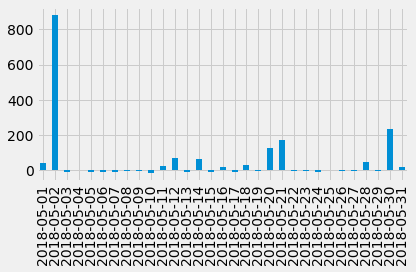

In [ ]:
ax = (ord_to_ckb
.sort("date")
.toPandas()
.plot(kind='bar', x='date', y='deptDelay', legend=None))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

dataFrame - zoptymalizowane pod kątem exportu damych z plików z kolumnani  CSV, JSON. Praca w kontekscie SQL. Szybsze niz RDD. Wykorzystujemy gdy używamy wysoko poziomowych funkcji API PySPARK takich jak agregacja, sortowanie

RDD - pierwotna struktura SPARKA, możliwa praca współdzielona w klastrze, zapewnia niezmienialnośc danych pierwotnych, możliwość odtworzenia danych początkowych np. w wyniku awarii. Nie maożna ich optymalizować w trakcie działania. Wolniejsze niż DataFrame. Gdy dane są nie ustrukturyzowane lub potrzebujemy działań niskiego poziomu. Np system rekomendacji fimów oparty na zbudowaniu profilu osoby oceniającej.
 
 
***GRAFY***
 
Graf w informatyce jest najbardziej skomplikowaną podstawową strukturą danych. Stosy, kolejki, listy i drzewa można traktować jako szczególne przypadki grafu lub grafy uproszczone.
Grafy dostarczają nam potężne możliwości tworzenia różnego rodzaju relacji pomiędzy danymi, które można wiązać na wiele różnych sposobów, reprezentując lub modelując złożone zależności z otaczającego nas świata.
Grafy możemy zaimplementować w postaci tablicy określającej rodzaj połączenia oraz jego etykietę lub dynamicznie korzystając ze wskaźników.